# Final Project
## Bike sharing application using Bayesian network

- Check where the file locate

In [14]:
pwd

'/Users/hchae/Desktop'

### Importing the Dataset

In [15]:
dataset = pd.read_csv("london_merged.csv")

In [5]:
dataset.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


### Use pyBBN for creating Bayesian Networks 

In [6]:
# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [5]:
pip install pybbn

  Created wheel for pybbn: filename=pybbn-3.2.1-py3-none-any.whl size=39725 sha256=90af64a9ef8b7fe21c01a218a09e9d77150d1504688632b06fb38b0a35918cac
  Stored in directory: /Users/hchae/Library/Caches/pip/wheels/06/80/2f/0e63fe5497b2917af3b7bdcbb142985ba4e5e5ef9a2c0b14b9
Successfully built pybbn
Note: you may need to restart the kernel to use updated packages.


### Function that calculates proabaility distribution

In [7]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

#### Further work needed - only few nodes are considered

In [38]:
#Create nodes by using our earlier function to automatically calculate probabilities
is_holiday = BbnNode(Variable(0, 'is_holiday', ['No', 'Yes']), probs(dataset, child='cnt'))
#is_weedend = BbnNode(Variable(1, 'is_weedend'), probs(df, child='cnt'))

season = BbnNode(Variable(1, 'season',['<=100', '>100']), probs(dataset, child='t1'))
t1 = BbnNode(Variable(2, 't1',['<=100', '>100']), probs(dataset, child='weather_code', parent1='season'))
weather_code = BbnNode(Variable(3, 'weather_code',['<=100', '>100']), probs(dataset,child='cnt',parent1='t1'))         
number = BbnNode(Variable(4, 'cnt',['<=100', '>100']), probs(dataset, child='cnt',parent1='is_holiday', parent2='weather_code'))
             

# Create Network
bbn = Bbn() \
    .add_node(is_holiday) \
    .add_node(season) \
    .add_node(t1) \
    .add_node(weather_code) \
    .add_node(number) \
    .add_edge(Edge(is_holiday, number, EdgeType.DIRECTED)) \
    .add_edge(Edge(season, t1, EdgeType.DIRECTED)) \
    .add_edge(Edge(t1, weather_code, EdgeType.DIRECTED)) \
    .add_edge(Edge(weather_code, number, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

### Drawing graphs

In [28]:
# for drawing graphs
import networkx as nx 
# for drawing graphs
import matplotlib.pyplot as plt

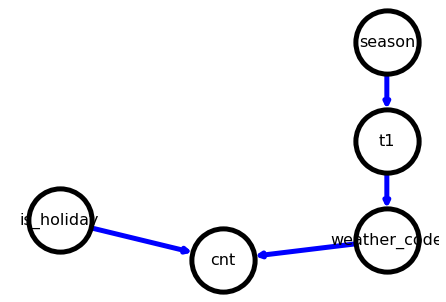

In [36]:
# Set node positions
pos = {0: (-1, 2), 1: (1, 20), 2: (1,10), 3: (1, 0), 4: (0, -2)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "blue",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [ ]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

### Use pandas for data manipulation

In [13]:
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator,BayesianEstimator

- Add the Bayesian network

In [ ]:
model = BayesianModel([("season","t1"),
                       ("season","hum"),
                       ("season","wind_speed"),
                       ("t1","weather_code"),
                       ("hum","weather_code"),
                       ("wind_speed","weather_code"),
                       ("weather_code","cnt"),
                       ("is_weekend","cnt"),
                       ("is_holiday","cnt")])

model.fit(dataset, estimator = MaximumLikelihoodEstimator)

/Users/hchae/opt/anaconda3/lib/python3.8/site-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


In [ ]:
# calculate individual prob
print(model.get_cpds('t1'))

In [ ]:
print